# 1 dimensional laws

In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf

2022-04-04 15:07:44.249860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-04 15:07:44.249920: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Wolfram's 256 Rules

These are all cellular automaton rules for a 1-d array with only neares neighbour interaction. There are therefore only three cells (L,C,R) determining the outcome of one cell (C). This gives 2^3=8 possible combinations that can give rise to an outcome of 2 possibilities. Thus there are 2^8=256 possible rules. 

The following function generates each of these rules.
 
Input:  
num = number of rule  
inp = string of input bits   
t = number of timesteps calculated  

Output: an array of arrays each for one timestep beginning with the input array. 

The boudary conditions are periodic
        

In [4]:
def CellularAutomata(num,inp,t):
    bnum = np.flip(np.fromiter(np.binary_repr(num,width=8),dtype=int))
    out = [np.fromiter(inp,dtype=int)]
    lin = len(inp)
    currinp = inp
    for n in range(t):
        outnow = []
        for i in range(len(inp)):
            outnow = np.append(outnow,bnum[int(str(currinp[(i-1)%lin])+str(currinp[(i)%lin])+str(currinp[(i+1)%lin]),2)])

        currinp =''.join([str(int(elem)) for elem in outnow])
        out = np.append(out,[outnow],axis=0)
    return(out)


## Generating Data

In [858]:
N=100 #batch size
L=3 #Length of box
rule= 40 #170 is movement to the left x_i' = x_{i+1}
time = 1

x_train=[]
y_train=[]


for i in range(N):
    #x=[0,0,0]
    #x[np.random.randint(0,3)]=1
    x=np.random.randint(0,2,L).astype(float)
    x_train.append(np.copy(x))
    #y_train.append(np.copy(CellularAutomata(rule,''.join([str(int(elem)) for elem in x]),time)[time]))
    y_train.append(np.copy(CellularAutomata(rule,''.join([str(int(elem)) for elem in x]),time)[time,1]))
    #print(''.join([str(int(elem)) for elem in x]),CellularAutomata(rule,''.join([str(int(elem)) for elem in x]),time)[time,0])

#for i in range(20):
 #   print(x_train[i],y_train[i])
    
x_train = np.array(x_train).reshape(N,L,1)
y_train = np.array(y_train).reshape(N,1)
#print(x_train.shape,y_train.shape)
#print(x_train[0],y_train[0],CellularAutomata(rule,''.join([str(int(elem)) for elem in x_train[0]]),time)[time])

## Models
useful resource for understanding what is going on:  
Padding https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/  
Guide to 2d conv layers https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/  
Guide to 1d conv layers https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/  
shapes, dimensions and units https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc  


### Dense layers

### 1-D Convolutional layer

Tutorial custom layers: https://www.tensorflow.org/tutorials/customization/custom_layers

In [847]:
class SimpleConv(tf.keras.layers.Layer):
    def __init__(self, num_neighbours):
        super(SimpleConv, self).__init__()
        self.num_neighbours = num_neighbours

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=[int(input_shape[-1]),
                                             self.num_neighbours])
#        self.kernel = self.add_weight("kernel",tf.constant([[0],[0],[1]]))
    #        self.bias = self.add_weight("bias",
#                                      shape=[int(input_shape[-1]),
 #                                            self.num_neighbours])

    def call(self, inputs):
        inshape = tf.shape(inputs)
#        return tf.matmul(inputs, self.kernel)
        return tf.reshape(tf.tensordot(inputs,self.kernel,axes=2),(inshape[0],1))
#        return tf.reshape(tf.tensordot(inputs,tf.constant([[0.,0,1]]),axes=2),(inshape[0],1))

layer = SimpleConv(3)
print(x_train[0:3])
print(y_train[0:3])
#layer.set_weights(np.array([1]))
print(layer(x_train[0:3]))
layer.set_weights([np.array([[0,0,1]])])
print(layer.get_weights())


[[[0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]]

 [[0.]
  [0.]
  [1.]]]
[[0.]
 [0.]
 [0.]]
tf.Tensor(
[[-0.       ]
 [-2.1434765]
 [-0.555727 ]], shape=(3, 1), dtype=float32)
[array([[0., 0., 1.]], dtype=float32)]


In [848]:
#layer = SimpleConv()
inp = x_train[0:5]

print(inp)
print( y_train[0:5])
#print(inp.shape)
#layer(inp)
#layer = tf.keras.layers.Conv1D(
#1,3, activation='relu', input_shape=((3,1)))
print(layer(inp))
print(layer.get_weights())


[[[0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]]

 [[0.]
  [0.]
  [1.]]

 [[1.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]]]
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]]
tf.Tensor(
[[0.]
 [1.]
 [1.]
 [0.]
 [0.]], shape=(5, 1), dtype=float32)
[array([[0., 0., 1.]], dtype=float32)]


In [859]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer((3,1))) 
model.add(SimpleConv(3))
#model.add(tf.keras.layers.Conv1D(1,3, activation='softmax', input_shape=((3,1))))
#model.add(tf.keras.layers.Conv1D(100,3, activation='relu', input_shape=((1,100))))
model.add(tf.keras.layers.Flatten())
tf.keras.layers.Softmax()

#model.add(tf.keras.layers.Dense(3,activation="relu"))
#model.add(tf.keras.layers.Dense(1,activation="softmax"))
#model.layers[0].set_weights([np.array([[1,1,1]])])#Initializing with almost the right law converges, but never with sometheing a bit more off
model.summary()

Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_conv_303 (SimpleConv) (None, 1)                 3         
_________________________________________________________________
flatten_108 (Flatten)        (None, 1)                 0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [853]:
print(model(x_train)[15:20])
print(y_train[15:20])

tf.Tensor(
[[ 0.        ]
 [ 0.28471947]
 [ 0.28471947]
 [-0.05720788]
 [ 0.        ]], shape=(5, 1), dtype=float32)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


## Execute learning

0.38424832
Epoch 1/200
4/4 [==============================] - 0s 1ms/step - loss: 0.3841 - accuracy: 0.7300
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 0.3838 - accuracy: 0.7300
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3837 - accuracy: 0.7300
Epoch 4/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3836 - accuracy: 0.7300
Epoch 5/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3835 - accuracy: 0.7300
Epoch 6/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3832 - accuracy: 0.7300
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3831 - accuracy: 0.7300
Epoch 8/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3829 - accuracy: 0.7300
Epoch 9/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3829 - accuracy: 0.7300
Epoch 10/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3828 - accuracy: 0.7300
Epoch 11/200
4/4 [

4/4 [==============================] - 0s 3ms/step - loss: 0.3814 - accuracy: 0.7300
Epoch 85/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3813 - accuracy: 0.7300
Epoch 86/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.7300
Epoch 87/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.7300
Epoch 88/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3813 - accuracy: 0.7300
Epoch 89/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3813 - accuracy: 0.7300
Epoch 90/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.7300
Epoch 91/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.7300
Epoch 92/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.7300
Epoch 93/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.7300
Epoch 94/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.3816 - accuracy: 0.7300
Epoch 168/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3815 - accuracy: 0.7300
Epoch 169/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3815 - accuracy: 0.7300
Epoch 170/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3815 - accuracy: 0.7300
Epoch 171/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3815 - accuracy: 0.7300
Epoch 172/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3815 - accuracy: 0.7300
Epoch 173/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3818 - accuracy: 0.7300
Epoch 174/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3818 - accuracy: 0.7300
Epoch 175/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3818 - accuracy: 0.7300
Epoch 176/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3817 - accuracy: 0.7300
Epoch 177/200
4/4 [=====

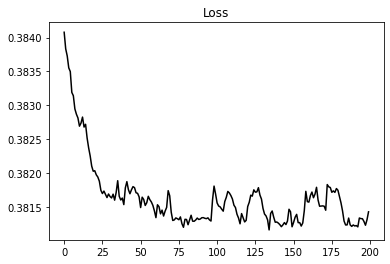

In [868]:
#loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
#loss_fn = tf.keras.metrics.BinaryAccuracy()
#loss_fn = tf.keras.losses.MeanSquaredError()

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction="auto",name="sparse_categorical_crossentropy")


predictions = model(x_train).numpy()
print(loss_fn(y_train, predictions).numpy())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss_fn,
              #metrics=[tf.keras.metrics.BinaryAccuracy()]
              metrics=['accuracy']
                #metrics= [tf.keras.losses.CategoricalCrossentropy()]
             )
train_history = model.fit(x=x_train, y=y_train, epochs=200,verbose=1)
plt.title("Loss")
plt.plot(train_history.history['loss'], 'k')

In [866]:
#print(x_train[0:3])
print(y_train[20:40])
np.around(model(x_train)[20:40].numpy())
#print(model.get_weights())

[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


array([[ 1.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 0.],
       [ 1.],
       [-0.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [-0.],
       [-0.],
       [ 1.]], dtype=float32)

In [790]:
CellularAutomata(10,[1,0,0],1)

array([[1., 0., 0.],
       [0., 0., 1.]])